In [1]:
import pandas as pd
import numpy as np
import glob
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

root_dir = '/oak/stanford/groups/horence/rob/isoform_localizations/'

sys.path.append(os.path.join(root_dir,'scripts'))
import spatial_utils
import plot_utils

Description of the metric

Running this new metric on only cells where the total spots per cell is 90th quantile
--> This is different than the gene-centric q90 filtering I’ve been doing, but makes sense here

For each spot in each cell, I will calculate the min distance to the cell boundary

Then I will take the x-th min quantile distance of spots from the same gene
--> This will leave me with the list of G number Julia described
--> Median would be 50-th quantile

Then I’ll order them and find the gene-percentile of each gene in the ordered list G
--> Not all genes will be in every cell. These will not be assigned quantiles

Then over all cells I can find the mean gene-percentile if I want to summarize over all cells


# Subsetting to cells/spots in q90

In [2]:
spots = pd.read_csv('../processed_data/all_passing_rna_spots.csv')
cells = pd.read_csv('../processed_data/segmented_cell_shapes.csv')

gene_spots_per_cell = spots.groupby(['target_molecule_name','cell_id']).size().reset_index(name='num_spots')
gene_spots_per_cell.head()

,target_molecule_name,cell_id,num_spots
0,1700022I11Rik,100024126192764500990464846159908804485,1
1,1700022I11Rik,100041328926932918570941555647599217925,1
2,1700022I11Rik,100067195941204343193847443517109677651,1
3,1700022I11Rik,100087079604313040350903416512866875178,1
4,1700022I11Rik,100106378211286780818879112257146169937,1


In [3]:
total_spots_per_cell = spots.groupby(['cell_id']).size().reset_index(name='total_spots')
total_spots_per_cell

,cell_id,total_spots
0,10000143038275111136124942858811168393,161
1,100007228202835962319771548915451072492,79
2,100013893144618144270850756017896167367,219
3,100017533667894826939857215877082515137,75
4,100018547319796564052034805202079258035,72
...,...,...
237944,99987465505639073211021560543065098772,549
237945,99989592830367590092304100078674096866,184
237946,99991756591196613545069880666241120777,27
237947,99997421766159526763299676887100858104,80


In [6]:
cell_subset = total_spots_per_cell[
    total_spots_per_cell['total_spots'] >
    total_spots_per_cell['total_spots'].quantile(0.9)
]

cell_ids = cell_subset['cell_id']

In [7]:
spots[spots['cell_id'].isin(cell_ids)].to_csv('../processed_data/q90_rna_spots.csv',index=False)

In [8]:
cells[cells['cell_id'].isin(cell_ids)].to_csv('../processed_data/q90_cells.csv',index=False)

# Creating the metric

In [2]:
spots = pd.read_csv('../processed_data/q90_rna_spots.csv')
cells = pd.read_csv('../processed_data/q90_cells.csv')

In [3]:
spots.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2
1,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2
2,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2
3,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2
4,-4270.8410,1726.0154,0.0,Acta2,1,29559620824861669263446897425219499530,mouse1sample2


In [4]:
shared_cell_ids = np.intersect1d(spots['cell_id'], cells['cell_id'])
shared_cell_ids

array(['100024126192764500990464846159908804485',
       '100038053095457998072343452615211305922',
       '100042292675978612289781789372249900646', ...,
       '99969166454721663399298872433695962292',
       '99985816691327783828891364793469425625',
       '99997470167777465101376150817407669505'], dtype=object)

In [90]:

import importlib
importlib.reload(spatial_utils)

def spatial_metric_periphery_quantile(spots,cells,pts=[90]):
    #Remove cells that have too few boundary points
    #Having 3 commas means 4 points which is min for shapely
    cells = cells[cells['boundaryX'].str.count(',').gt(3)]

    #Limit the spots to just the shared cell_ids
    shared_cell_ids = np.intersect1d(spots['cell_id'], cells['cell_id'])
    spots = spots[spots['cell_id'].isin(shared_cell_ids)]
    cells = cells[cells['cell_id'].isin(shared_cell_ids)]

    #Calculate num_cell_spots and num_gene_spots
    spots = spatial_utils.calculate_spots_per_cell(spots) #NOTE

    #Calculate spot to boundary min dist
    spots = spatial_utils.calculate_spot_to_boundary_min_dist(spots, cells) #NOTE
    spots = spots.rename(columns={'min_boundary_dist':'raw_metric'})
    
    for pt in pts:
        spots['pt{}'.format(pt)] = (
            spots.groupby(['cell_id','target_molecule_name'])
            ['raw_metric']
            .transform(lambda x: np.percentile(x,pt))
        )
        
        
    periphery_df = spots.drop_duplicates(['cell_id','target_molecule_name'])
    periphery_df['metric_name'] = 'periphery_quantile'
    
    for pt in pts:
        periphery_df['gene_pt{}'.format(pt)] = (
            periphery_df.groupby('cell_id')
            ['pt{}'.format(pt)]
            .transform(
                lambda x: [(x <= v).sum()/len(x) for v in x]
            )
        )

    #Get the output into the standard metric table
    pt_cols = ['pt{}'.format(pt) for pt in pts]
    gene_pt_cols = ['gene_pt{}'.format(pt) for pt in pts]
    cols = [
       'cell_id', 'target_molecule_name',
       'num_cell_spots', 'num_gene_spots',
       'metric_name',
    ]+pt_cols+gene_pt_cols
    metric_df = periphery_df[cols]


    return metric_df


sub_shared_cell_ids = np.random.choice(shared_cell_ids,10)
sub_spots = spots[spots['cell_id'].isin(sub_shared_cell_ids)]
sub_cells = cells[cells['cell_id'].isin(sub_shared_cell_ids)]
        
        
x = spatial_metric_periphery_quantile(sub_spots,sub_cells,pts=[0,10,50,90,100])
x.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,pt0,pt10,pt50,pt90,pt100,gene_pt0,gene_pt10,gene_pt50,gene_pt90,gene_pt100
549223,85031847036103281597584140113790170404,Acta2,1060,4,periphery_quantile,0.537835,0.649925,0.960802,1.215099,1.302940,0.400000,0.318519,0.133333,0.148148,0.155556
549235,85031847036103281597584140113790170404,Adra1b,1060,39,periphery_quantile,0.095807,0.471818,1.748374,2.738848,3.658965,0.111111,0.192593,0.400000,0.451852,0.696296
549265,85031847036103281597584140113790170404,Ano4,1060,5,periphery_quantile,0.628732,0.681794,1.990117,2.855836,3.200593,0.451852,0.333333,0.503704,0.496296,0.570370
549307,85031847036103281597584140113790170404,Bmpr1b,1060,8,periphery_quantile,0.091151,0.854601,3.465039,3.883232,4.004393,0.096296,0.429630,0.933333,0.918519,0.822222
549312,85031847036103281597584140113790170404,C1ql3,1060,12,periphery_quantile,0.624902,0.804549,1.680811,2.717646,2.783271,0.444444,0.407407,0.355556,0.437037,0.429630


In [70]:
x[x['target_molecule_name'].eq('Flrt3')]

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,pt0,pt10,pt50,pt90,pt100,gene_pt0,gene_pt10,gene_pt50,gene_pt90,gene_pt100
61385,23370715410096682887823477427598306217,Flrt3,820,2,periphery_quantile,0.673172,0.941220,2.013415,3.085610,3.353658,0.313131,0.222222,0.282828,0.272727,0.313131
119594,289662746682429203260793386189081828527,Flrt3,1037,2,periphery_quantile,0.678908,0.735556,0.962148,1.188740,1.245388,0.480392,0.333333,0.137255,0.107843,0.107843
197106,253448290242530955699380762419815251205,Flrt3,958,3,periphery_quantile,0.173635,0.711448,2.862698,3.306867,3.417909,0.226027,0.458904,0.890411,0.664384,0.582192
310094,204332642477467411565335870969214458568,Flrt3,908,6,periphery_quantile,1.656226,1.884916,3.466243,6.184795,6.814568,0.653226,0.669355,0.782258,0.975806,0.991935
311955,115055064092744544419092403485012432264,Flrt3,862,4,periphery_quantile,1.393034,1.688304,3.277544,4.704754,4.930582,0.634783,0.643478,0.826087,0.800000,0.660870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22364161,36074138137044842327892808514945524897,Flrt3,832,14,periphery_quantile,0.694156,1.148454,2.366597,3.528222,4.346724,0.402299,0.379310,0.459770,0.459770,0.586207
22429566,140093804636861471576903602525555264826,Flrt3,1004,3,periphery_quantile,2.364299,2.849267,4.789137,6.277867,6.650050,0.729508,0.803279,0.959016,0.983607,0.934426
22456851,147457300699532487339322620982358626283,Flrt3,1153,9,periphery_quantile,0.451961,0.751602,3.428207,5.525646,5.685225,0.346457,0.299213,0.811024,0.897638,0.795276
22559551,49394438678465740779623022396384644366,Flrt3,953,1,periphery_quantile,3.023062,3.023062,3.023062,3.023062,3.023062,0.826923,0.817308,0.778846,0.403846,0.394231


In [92]:
import importlib
importlib.reload(spatial_utils)
spatial_utils.calculate_spot_to_boundary_min_dist(sub_spots, sub_cells)

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample,min_boundary_dist
549223,4038.8620,2572.0266,0.0,Acta2,1,85031847036103281597584140113790170404,mouse1sample2,1.010137
549224,4037.6450,2573.3352,0.0,Acta2,1,85031847036103281597584140113790170404,mouse1sample2,1.302940
549235,4040.6677,2567.2922,0.0,Adra1b,1,85031847036103281597584140113790170404,mouse1sample2,0.543274
549236,4052.9307,2567.3700,0.0,Adra1b,1,85031847036103281597584140113790170404,mouse1sample2,1.180939
549237,4039.7812,2568.3640,0.0,Adra1b,1,85031847036103281597584140113790170404,mouse1sample2,0.793420
...,...,...,...,...,...,...,...,...
22215618,4028.2126,2809.9400,9.0,Sulf2,1,219129285704929874187749726331141972431,mouse1sample3,2.555253
22215627,4031.5620,2804.0847,9.0,Syndig1,1,219129285704929874187749726331141972431,mouse1sample3,3.987351
22215673,4028.5828,2799.3162,9.0,Trpc4,1,219129285704929874187749726331141972431,mouse1sample3,1.516410
22215693,4023.8608,2802.4443,9.0,Unc5d,1,219129285704929874187749726331141972431,mouse1sample3,4.178531


In [73]:
rand_genes = np.random.choice(x['target_molecule_name'].unique(),10)
rand_genes

array(['Adam2', 'Blank-5', 'Aqp4', 'Igfbp4', 'Opalin', 'Ctss', 'Spon1',
       'Asic4', 'Trp53i11', '5730522E02Rik'], dtype=object)

In [76]:
x.groupby('cell_id')['target_molecule_name'].unique().apply(len).mean()

114.398

In [85]:
x.columns

Index(['cell_id', 'target_molecule_name', 'num_cell_spots', 'num_gene_spots',
       'metric_name', 'pt0', 'pt10', 'pt50', 'pt90', 'pt100', 'gene_pt0',
       'gene_pt10', 'gene_pt50', 'gene_pt90', 'gene_pt100'],
      dtype='object')

In [81]:
x.groupby(['cell_id','target_molecule_name']).size().quantile(0.)

1.0

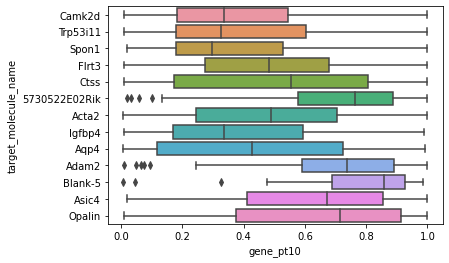

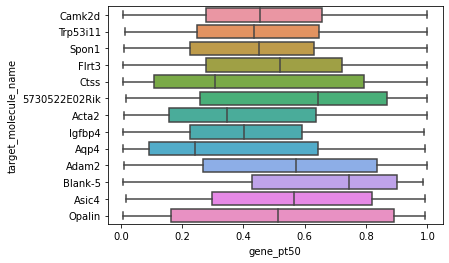

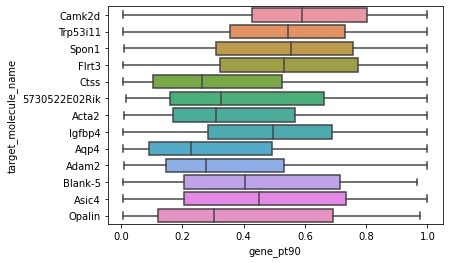

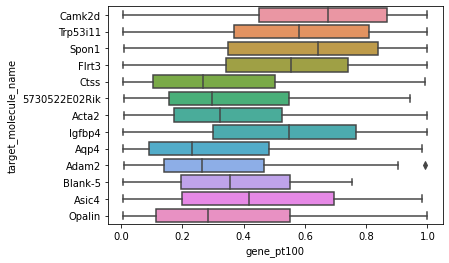

In [86]:
genes = ['Acta2','Flrt3','Camk2d']+list(rand_genes)

sns.boxplot(
    y = 'target_molecule_name',
    x = 'gene_pt10',
    data = x[x['target_molecule_name'].isin(genes)],
)
plt.show()
plt.close()

sns.boxplot(
    y = 'target_molecule_name',
    x = 'gene_pt50',
    data = x[x['target_molecule_name'].isin(genes)],
)
plt.show()
plt.close()

sns.boxplot(
    y = 'target_molecule_name',
    x = 'gene_pt90',
    data = x[x['target_molecule_name'].isin(genes)],
)
plt.show()
plt.close()

sns.boxplot(
    y = 'target_molecule_name',
    x = 'gene_pt100',
    data = x[x['target_molecule_name'].isin(genes)],
)
plt.show()
plt.close()



Then I’ll order them and find the gene-percentile of each gene in the ordered list G --> Not all genes will be in every cell. These will not be assigned quantiles

Then over all cells I can find the mean gene-percentile if I want to summarize over all cells

In [87]:
x.to_csv('../processed_data/20210120_periphery_quantile.csv',index=False)

In [ ]:
'/oak/stanford/groups/horence/rob/isoform_localizations/processed_data/20210120_periphery_quantile.csv'

cell_id                                  target_molecule_name
105342185141734385992235577168782074329  Acta2                   2.256840
                                         Adra1b                  1.014912
                                         Alk                     2.447696
                                         Ano4                    1.549853
                                         B4galnt2                6.390875
                                                                   ...   
95681852701989545925128508145403806796   Ubash3b                 2.378813
                                         Unc5d                   1.393600
                                         Vwc2                    0.410952
                                         Wipf3                   3.013040
                                         Zfp804b                 3.752488
Name: raw_metric, Length: 11396, dtype: float64